In [4]:
import sys
import math 
import time 
from tqdm import tqdm
import matplotlib.pyplot as plt
B = 4
    

In [2]:
class Node(object): #node class
    def __init__(self):
        self.id = 0
        # for internal nodes
        self.child_nodes = []
        # for leaf nodes
        self.data_points = []
        self.parent = None
        self.MBR = {
            'x1': -1,
            'y1': -1,
            'x2': -1,
            'y2': -1,
        }
    def perimeter(self):
        # only calculate the half perimeter here
        return (self.MBR['x2'] - self.MBR['x1']) + (self.MBR['y2'] - self.MBR['y1'])

    def is_overflow(self):
        if self.is_leaf():
            if self.data_points.__len__() > B: #Checking overflows of data points, B is the upper bound.
                return True
            else:
                return False
        else:
            if self.child_nodes.__len__() > B: #Checking overflows of child nodes, B is the upper bound.
                return True
            else:
                return False

    def is_root(self):
        if self.parent is None:
            return True
        else:
            return False

    def is_leaf(self):
        if self.child_nodes.__len__() == 0:
            return True
        else:
            return False



In [3]:
class RTree(object): #R tree class
    def __init__(self):
        self.root = Node() #Create a root
    def insert(self, u, p): # insert p(data point) to u (MBR)
        if u.is_leaf(): 
            self.add_data_point(u, p) #add the data point and update the corresponding MBR
            if u.is_overflow():
                self.handle_overflow(u) #handel overflow for leaf nodes
        else:
            v = self.choose_subtree(u, p) #choose a subtree to insert the data point to miminize the perimeter sum
            self.insert(v, p) #keep continue to check the next layer recursively
            self.update_mbr(v) #update the MBR for inserting the data point

    def choose_subtree(self, u, p): 
        if u.is_leaf(): #find the leaf and insert the data point
            return u
        else:
            min_increase = sys.maxsize #set an initial value
            best_child = None
            for child in u.child_nodes: #check each child to find the best node to insert the point 
                if min_increase > self.peri_increase(child, p):
                    min_increase = self.peri_increase(child, p)
                    best_child = child
            return best_child

    def peri_increase(self, node, p): # calculate the increase of the perimeter after inserting the new data point
        # new perimeter - original perimeter = increase of perimeter
        origin_mbr = node.MBR
        x1, x2, y1, y2 = origin_mbr['x1'], origin_mbr['x2'], origin_mbr['y1'], origin_mbr['y2']
        increase = (max([x1, x2, p['x']]) - min([x1, x2, p['x']]) +
                    max([y1, y2, p['y']]) - min([y1, y2, p['y']])) - node.perimeter()
        return increase


    def handle_overflow(self, u):
        u1, u2 = self.split(u) #u1 u2 are the two splits returned by the function "split"
        # if u is root, create a new root with s1 and s2 as its' children
        if u.is_root():
            new_root = Node()
            self.add_child(new_root, u1)
            self.add_child(new_root, u2)
            self.root = new_root
            self.update_mbr(new_root)
        # if u is not root, delete u, and set s1 and s2 as u's parent's new children
        else:
            w = u.parent
            # copy the information of s1 into u
            w.child_nodes.remove(u)
            self.add_child(w, u1) #link the two splits and update the corresponding MBR
            self.add_child(w, u2)
            if w.is_overflow(): #check the parent node recursively
                self.handle_overflow(w)
            
    def split(self, u):
        # split u into s1 and s2
        best_s1 = Node()
        best_s2 = Node()
        best_perimeter = sys.maxsize
        # u is a leaf node
        if u.is_leaf():
            m = u.data_points.__len__()
            # create two different kinds of divides
            divides = [sorted(u.data_points, key=lambda data_point: data_point['x']),
                       sorted(u.data_points, key=lambda data_point: data_point['y'])] #sorting the points based on X dimension and Y dimension
            for divide in divides:
                for i in range(math.ceil(0.4 * B), m - math.ceil(0.4 * B) + 1): #check the combinations to find a near-optimal one
                    s1 = Node()
                    s1.data_points = divide[0: i]
                    self.update_mbr(s1)
                    s2 = Node()
                    s2.data_points = divide[i: divide.__len__()]
                    self.update_mbr(s2)
                    if best_perimeter > s1.perimeter() + s2.perimeter(): 
                        best_perimeter = s1.perimeter() + s2.perimeter()
                        best_s1 = s1
                        best_s2 = s2

        # u is a internal node
        else:
            # create four different kinds of divides
            m = u.child_nodes.__len__()
            divides = [sorted(u.child_nodes, key=lambda child_node: child_node.MBR['x1']), #sorting based on MBRs
                       sorted(u.child_nodes, key=lambda child_node: child_node.MBR['x2']),
                       sorted(u.child_nodes, key=lambda child_node: child_node.MBR['y1']),
                       sorted(u.child_nodes, key=lambda child_node: child_node.MBR['y2'])]
            for divide in divides:
                for i in range(math.ceil(0.4 * B), m - math.ceil(0.4 * B) + 1): #check the combinations
                    s1 = Node()
                    s1.child_nodes = divide[0: i]
                    self.update_mbr(s1)
                    s2 = Node()
                    s2.child_nodes = divide[i: divide.__len__()]
                    self.update_mbr(s2)
                    if best_perimeter > s1.perimeter() + s2.perimeter():
                        best_perimeter = s1.perimeter() + s2.perimeter()
                        best_s1 = s1
                        best_s2 = s2

        for child in best_s1.child_nodes:
            child.parent = best_s1
        for child in best_s2.child_nodes:
            child.parent = best_s2

        return best_s1, best_s2


    def add_child(self, node, child):
        node.child_nodes.append(child) #add child nodes to the current parent (node) and update the MBRs. It is used in handeling overflows
        child.parent = node
        if child.MBR['x1'] < node.MBR['x1']:
            node.MBR['x1'] = child.MBR['x1']
        if child.MBR['x2'] > node.MBR['x2']:
            node.MBR['x2'] = child.MBR['x2']
        if child.MBR['y1'] < node.MBR['y1']:
            node.MBR['y1'] = child.MBR['y1']
        if child.MBR['y2'] > node.MBR['y2']:
            node.MBR['y2'] = child.MBR['y2']
    # return the child whose MBR requires the minimum increase in perimeter to cover p

    def add_data_point(self, node, data_point): #add data points and update the the MBRS
        node.data_points.append(data_point)
        if data_point['x'] < node.MBR['x1']:
            node.MBR['x1'] = data_point['x']
        if data_point['x'] > node.MBR['x2']:
            node.MBR['x2'] = data_point['x']
        if data_point['y'] < node.MBR['y1']:
            node.MBR['y1'] = data_point['y']
        if data_point['y'] > node.MBR['y2']:
            node.MBR['y2'] = data_point['y']


    def update_mbr(self, node): #update MBRs when forming a new MBR. It is used in checking the combinations and update the root
        x_list = []
        y_list = []
        if node.is_leaf():
            x_list = [point['x'] for point in node.data_points]
            y_list = [point['y'] for point in node.data_points]
        else:
            x_list = [child.MBR['x1'] for child in node.child_nodes] + [child.MBR['x2'] for child in node.child_nodes]
            y_list = [child.MBR['y1'] for child in node.child_nodes] + [child.MBR['y2'] for child in node.child_nodes]
        new_mbr = {
            'x1': min(x_list),
            'x2': max(x_list),
            'y1': min(y_list),
            'y2': max(y_list)
        }
        node.MBR = new_mbr


In [6]:
def build_rtree(dataset):
    rtree = RTree()
    total_points = len(dataset)

    with tqdm(total=total_points, desc='Building R-tree') as pbar:
        for i, point in enumerate(dataset):
            rtree.insert(rtree.root, point)
            pbar.update(1)
            time.sleep(0.01)  # Optional: Sleep to control the progress bar speed

    return rtree


In [7]:
def visualize_rtree(rtree, query_results=None):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    # Plot the R-tree nodes
    plot_node(rtree.root, ax, 'blue')

    # Plot the query results if provided
    if query_results:
        for point in query_results:
            ax.plot(point['x'], point['y'], 'ro')

    plt.xlim(0, 11)
    plt.ylim(0, 8)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('R-tree Visualization')

    plt.show()

def plot_node(node, ax, color):
    if node.is_leaf():
        for point in node.data_points:
            ax.plot(point['x'], point['y'], 'o', color=color)
    else:
        for child in node.child_nodes:
            plot_node(child, ax, color)

            x_vals = [child.MBR['x1'], child.MBR['x1'], child.MBR['x2'], child.MBR['x2'], child.MBR['x1']]
            y_vals = [child.MBR['y1'], child.MBR['y2'], child.MBR['y2'], child.MBR['y1'], child.MBR['y1']]

            ax.plot(x_vals, y_vals, color=color)

def range_query(rtree, x1, y1, x2, y2):
    query_results = []

    def search(node):
        if node.is_leaf():
            for point in node.data_points:
                if x1 <= point['x'] <= x2 and y1 <= point['y'] <= y2:
                    query_results.append(point)
        else:
            for child in node.child_nodes:
                if x1 <= child.MBR['x2'] and x2 >= child.MBR['x1'] and y1 <= child.MBR['y2'] and y2 >= child.MBR['y1']:
                    search(child)

    search(rtree.root)

    return query_results


In [15]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_rtree_tree(rtree):
    # Create a directed graph
    G = nx.DiGraph()

    # Traverse the R-tree and add nodes and edges to the graph
    def traverse(node, parent_id):
        if node.is_leaf():
            # Add leaf node to the graph
            node_id = str(id(node))
            G.add_node(node_id, label="Leaf Node", color="yellow")
            G.add_edge(parent_id, node_id)
        else:
            # Add internal node to the graph
            node_id = str(id(node))
            G.add_node(node_id, label="Internal Node", color="pink")
            G.add_edge(parent_id, node_id)

            # Recursively traverse child nodes
            for child in node.child_nodes:
                traverse(child, node_id)

    # Add the root node to the graph
    root_id = str(id(rtree.root))
    G.add_node(root_id, label="Root Node", color="red")

    # Traverse the R-tree starting from the root
    traverse(rtree.root, root_id)

    # Prepare node labels and colors for visualization
    node_labels = {node_id: data['label'] for node_id, data in G.nodes(data=True)}
    node_colors = [data['color'] for _, data in G.nodes(data=True)]

    # Visualize the tree structure
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='black')

    plt.title('R-tree Tree Structure')
    plt.axis('off')
    plt.show()






Building R-tree: 100%|██████████| 10/10 [00:00<00:00, 97.24it/s]


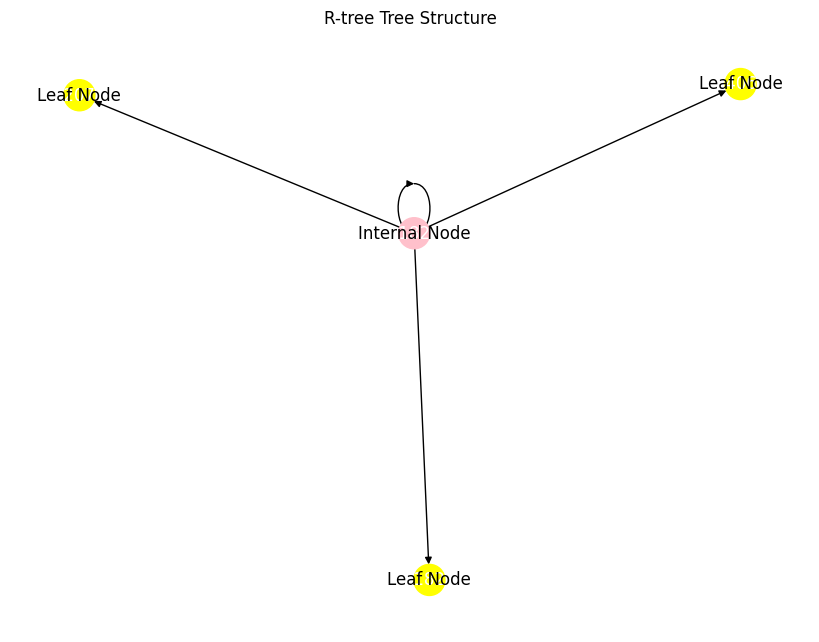

In [16]:
dataset = [
        {'x': 1, 'y': 3},
        {'x': 4, 'y': 1},
        {'x': 2, 'y': 5},
        {'x': 5, 'y': 3},
        {'x': 7, 'y': 2},
        {'x': 8, 'y': 4},
        {'x': 3, 'y': 6},
        {'x': 0, 'y': 7},
        {'x': 10, 'y': 4},
        {'x': 8, 'y': 1}
    ]

rtree = build_rtree(dataset)

# Visualize the R-tree as a tree structure
visualize_rtree_tree(rtree)

Building R-tree: 100%|██████████| 10/10 [00:00<00:00, 96.68it/s]


[{'x': 5, 'y': 3}, {'x': 7, 'y': 2}, {'x': 8, 'y': 4}]


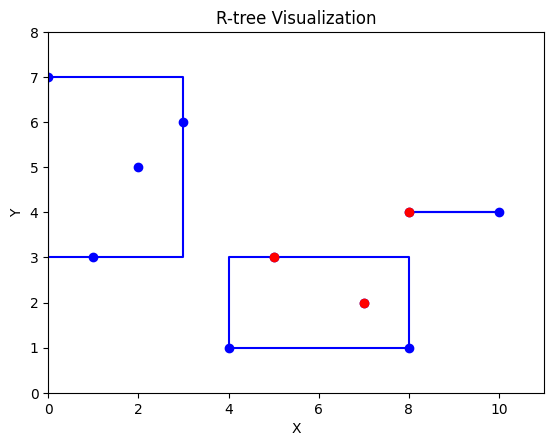

In [9]:
dataset = [
        {'x': 1, 'y': 3},
        {'x': 4, 'y': 1},
        {'x': 2, 'y': 5},
        {'x': 5, 'y': 3},
        {'x': 7, 'y': 2},
        {'x': 8, 'y': 4},
        {'x': 3, 'y': 6},
        {'x': 0, 'y': 7},
        {'x': 10, 'y': 4},
        {'x': 8, 'y': 1}
    ]

rtree = build_rtree(dataset)
query_results = range_query(rtree, 5, 2, 9, 6)
print (query_results)
visualize_rtree(rtree, query_results)
